In [ ]:
# 설치
!pip install requests beautifulsoup4 fake-useragent pandas matplotlib wordcloud seaborn

In [ ]:
import requests
from bs4 import BeautifulSoup
import base64
from fake_useragent import UserAgent
import os
import json
import time
import random
import pandas as pd

hakbun = "2025114794"
password = "AdvancedPythonTemp1!"
password = os.getenv("pw", password)

In [ ]:
class BiskitCrawler:
    def __init__(self):
        self.session = requests.Session()
        headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'User-Agent': UserAgent().random,
        }
        self.session.headers.update(headers)
        self.biskit_Cookie = self.biskit_login()
        self.session.headers.update({'Cookie': self.biskit_Cookie})
        self.df = pd.DataFrame(columns=['id', 'post_id', 'title', 'author', 'org', 'category', 'period', 'mileage', 'text'])

    def get_jsessionid(self):
        jsessionid4_url = "https://biskit.kumoh.ac.kr"
        jsessionid4_res = self.session.get(jsessionid4_url)

        JSESSIONID4 = jsessionid4_res.cookies['JSESSIONID4']
        WMONID = jsessionid4_res.cookies['WMONID']

        logout_url = "https://biskit.kumoh.ac.kr/common/user/logout.do"
        self.session.headers.update({'Cookie': f'JSESSIONID4={JSESSIONID4}; WMONID={WMONID};'})
        logout_res = self.session.get(logout_url, allow_redirects=False)

        login_url = "https://biskit.kumoh.ac.kr/common/user/login.do"

        self.session.headers.update({'Cookie': f'JSESSIONID4={JSESSIONID4}; WMONID={WMONID};'})
        login_res = self.session.get(login_url)
        JSESSIONID4 = login_res.cookies['JSESSIONID4']

        jsessionid_url = "https://onekit.kumoh.ac.kr/index.jsp"
        self.session.headers.update({'Cookie': f'JSESSIONID4={JSESSIONID4};'})
        jsessionid_res = self.session.get(jsessionid_url, allow_redirects=False)
        JSESSIONID = jsessionid_res.cookies['JSESSIONID']

        return JSESSIONID4, JSESSIONID, WMONID

    def biskit_login(self):
        JSESSIONID4, JSESSIONID, WMONID = self.get_jsessionid()

        Cookie = f'WMONID={WMONID}; JSESSIONID4={JSESSIONID4}; JSESSIONID={JSESSIONID};'
        biskit_Cookie = f'WMONID={WMONID}; JSESSIONID4={JSESSIONID4}; G_ENABLED_IDPS=google;'

        first_url = "https://biskit.kumoh.ac.kr/sso/index.jsp"

        self.session.headers.update({'Cookie': biskit_Cookie})

        first_res = self.session.get(first_url, allow_redirects=False)

        second_url = first_res.headers['Location']
        self.session.headers.update({'Cookie': Cookie})
        second_res = self.session.get(second_url, allow_redirects=False)

        ORIGINAL_JESSIONID = second_res.cookies['JSESSIONID']

        login_url = "https://onekit.kumoh.ac.kr/proc/Login.eps"

        login_data = {
            'user_id': hakbun,
            'user_password':  password,
        }
        self.session.headers.update({'Cookie': Cookie})
        login_res = self.session.post(login_url, data=login_data, allow_redirects=False)

        JSESSIONID = login_res.cookies['JSESSIONID']
        Cookie = f'WMONID={WMONID}; JSESSIONID4={JSESSIONID4}; JSESSIONID={JSESSIONID};'

        sso_url = login_res.headers['Location']
        self.session.headers.update({'Cookie': f"JSESSIONID={ORIGINAL_JESSIONID}; JSESSIONID4={JSESSIONID4};"})
        sso_res = self.session.get(sso_url, allow_redirects=False)

        biskit_url = "https://biskit.kumoh.ac.kr/sso/index.jsp"

        self.session.headers.update({'Cookie': biskit_Cookie})
        biskit_res = requests.get(biskit_url, allow_redirects=False)

        biskit_sso_url = biskit_res.headers['Location']
        self.session.headers.update({'Cookie': f"JSESSIONID4={JSESSIONID4}; JSESSIONID={ORIGINAL_JESSIONID}; _SSO_Global_Logout_url=get%5Ehttps%3A%2F%2Fonekit.kumoh.ac.kr%2Flogout.jsp%3Flogout%3D1%24"})
        biskit_sso_res = self.session.get(biskit_sso_url, allow_redirects=False)

        biskit_sso_1_url = biskit_sso_res.headers['Location']

        self.session.headers.update({'Cookie': biskit_Cookie})
        biskit_sso_1_res = self.session.get(biskit_sso_1_url, allow_redirects=False)

        biskit_login_url = biskit_sso_1_res.headers['Location']

        self.session.headers.update({'Cookie': biskit_Cookie})
        biskit_login_res = self.session.get(biskit_login_url, allow_redirects=False)

        biskit_sso_2_url = biskit_login_res.headers['Location']

        self.session.headers.update({'Cookie': biskit_Cookie})
        biskit_sso_2_res = self.session.get(biskit_sso_2_url, allow_redirects=False)

        biskit_sso_2_soup = BeautifulSoup(biskit_sso_2_res.text, 'html.parser')
        userId = biskit_sso_2_soup.find('input', {'name': 'userId'})['value']

        biskit_login_proc_url = "https://biskit.kumoh.ac.kr/common/user/loginProc.do"

        biskit_login_proc_data = {
            'userId': userId,
            'rtnUrl': ''
        }
        self.session.headers.update({'Cookie': biskit_Cookie})
        biskit_login_proc_res = self.session.post(biskit_login_proc_url, data=biskit_login_proc_data, allow_redirects=False)

        return biskit_Cookie
    def get_preview(self, post_id):
        biskit_link = "https://biskit.kumoh.ac.kr"

        link = f"{biskit_link}/ptfol/imng/icmpNsbjtPgm/findIcmpNsbjtPgmInfo.do?encSddpbSeq={post_id}"

        html = self.session.get(link).text
        soup = BeautifulSoup(html, 'html.parser')

        text_list = soup.find('div', {"class": "table_wrap"}).find('tbody')
        text_list = soup.find('div', {"class": "table_wrap"}).find('tbody').find_all('tr')[-1].find_all('p')

        text = ''
        for i in text_list:
            text += i.getText().replace(r'\xa0', '') + " "

        title = soup.find('div', {"class": "tab_top_wrap"}).find('h4').text.strip()
        for i in soup.find('div', {"class": "table_wrap"}).find('tbody').find_all('tr'):
            
            if not i.find('th'):
                continue

            if i.find('th').text.strip() == "운영조직":
                org = i.find_all('td')[0].text.strip()
                author = i.find_all('td')[1].text.strip()

            elif i.find('th').text.strip() == "프로그램 분류":
                category = i.find('td').text.strip()

            elif i.find('th').text.strip() == "신청기간":
                period = i.find('td').text.strip().replace(r'\xa0', ' ')

            elif i.find('th').text.strip() == "수료 인증서":
                try:
                    mileage = int(i.find_all('td')[1].text.strip())
                except:
                    mileage = 0
                
        post = (0, post_id, title, author, org, category, period, mileage)
        self.df.loc[len(self.df)] = post + (text,)
        return post
    def get_page(self, page_num):
        biskit_page_link = f"https://biskit.kumoh.ac.kr/ptfol/imng/icmpNsbjtPgm/findIcmpNsbjtPgmList.do?paginationInfo.currentPageNo={page_num}&sort=0001&chkAblyCount=0&vshOrgid=0000&_mandYnList=on&_mandYnList=on&keywordSh=&eduFrDtSh=&eduToDtSh=&aplyFrDtSh=&aplyToDtSh=&_recrStaList=on&_recrStaList=on&_recrStaList=on&_aplyPgmSh=on&_jobClReplYnSh=on&searchValue=&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&_yuCoreAblyCdList=on&eduFrDt=&eduToDt="

        biskit_page_res = self.session.get(biskit_page_link)

        biskit_page_soup = BeautifulSoup(biskit_page_res.text, 'html.parser')
        
        for page in biskit_page_soup.find_all('div', class_='t_img_w'):
            data_json = page.find('a', class_='detailBtn')['data-params']
            data = json.loads(data_json)
            post_id = data['encSddpbSeq']
            post = self.get_preview(post_id)
            print(post)
            time.sleep(random.uniform(1, 2))

In [ ]:
if __name__ == "__main__":
    crawler = BiskitCrawler()
    # for i in range(1, 2):
    for i in range(1, 235):
        crawler.get_page(i)

    crawler.df.to_csv("biskit_data.csv", index=False)



NameError: name 'BiskitCrawler' is not defined

In [49]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import matplotlib.font_manager as fm

path = r"C:\Windows\Fonts\malgun.ttf"
fontprop = fm.FontProperties(fname=path)

# id,post_id,title,author,org,category,period,mileage,text
def data_preprocessing(df):
    print("📊 원본 데이터 정보:")
    print(f"- 총 레코드 수: {len(df)}")
    print(f"- 컬럼 수: {len(df.columns)}")
    print(f"- 결측값: {df.isnull().sum().sum()}개")
    print(f"- 카테고리 결측값: {df['category'].isnull().sum()}개")
    
    df_clean = df.copy()
        
    # 4. 텍스트 정제 (제목)
    df_clean['title_clean'] = df_clean['title'].apply(clean_text)
    df_clean['text_clean'] = df_clean['text'].apply(clean_text)
    
    print(f"✅ 전처리 완료: {len(df_clean)}개 레코드")
    
    return df_clean

def clean_text(text):
    """텍스트 정제 함수"""
    if pd.isna(text):
        return ""
    
    # 특수문자 제거 (한글, 영문, 숫자, 공백만 유지)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', str(text))
    
    # 연속된 공백을 하나로 변경
    text = re.sub(r'\s+', ' ', text)
    
    # 앞뒤 공백 제거
    text = text.strip()
    
    return text

def extract_keywords(text_series):
    """키워드 추출 함수"""
    # 모든 텍스트를 하나로 합치기
    all_text = ' '.join(text_series.astype(str))
    
    # 단어 분리 (간단한 공백 기준)
    words = all_text.split()
    
    # 불용어 제거 (간단한 예시)
    stop_words = {'의', '가', '이', '은', '는', '을', '를', '에', '와', '과', '으로', '로', '에서', '와', '과', '뉴스', '기사', '관련', '위한', '3개월간', '참여를', '않고', '불참시', '제한', '제한합니다', '취소하지', '2024년', '1학기', '종료', '입니다'}
    words = [word for word in words if len(word) > 1 and word not in stop_words]
    
    # 빈도 계산
    word_freq = Counter(words)
    
    return word_freq.most_common(20)

# 데이터 생성 및 전처리 실행
biskit_df = pd.read_csv("biskit_data.csv", encoding='utf-8-sig')
clean_df = data_preprocessing(biskit_df)

print("\n📋 전처리된 데이터 미리보기:")
print(clean_df.head())

print("\n🔍 기본 통계:")
print(clean_df.describe())

📊 원본 데이터 정보:
- 총 레코드 수: 1960
- 컬럼 수: 9
- 결측값: 568개
- 카테고리 결측값: 513개
✅ 전처리 완료: 1960개 레코드

📋 전처리된 데이터 미리보기:
   id         post_id                                              title  \
0   0  31303033333839                      [자율전공학부] 산업체 견학-대한항공 테크센터(부산)   
1   0  31303033333838                              Unity6 WebGL 제작·배포 과정   
2   0  31303033333837                               2025년 졸업(예정)생 직무부트캠프   
3   0  31303033333836         [RISE사업단] 2025 항공방위물류 박람회 및 기업체 채용설명회(구미코)   
4   0  31303033333835  [취업특강 1회차] 키다리보안 아저씨 이창선 대표에게 듣는 "각 기업에서 요구하는 ...   

            author          org category                               period  \
0  황서영(0544787573)       자율전공학부      NaN  2025.09.11 00:00 ~ 2025.09.19 23:59   
1  김양현(0544787519)      컴퓨터공학전공      NaN  2025.09.11 00:00 ~ 2025.09.19 22:00   
2  최유림(0544787972)   대학일자리플러스센터      취창업  2025.09.11 12:00 ~ 2025.09.21 23:59   
3  이소연(0544786724)      RISE사업단      NaN  2025.09.11 13:10 ~ 2025.09.16 18:00   
4  류수연(0544787266)  SW전문인재양성사업단 

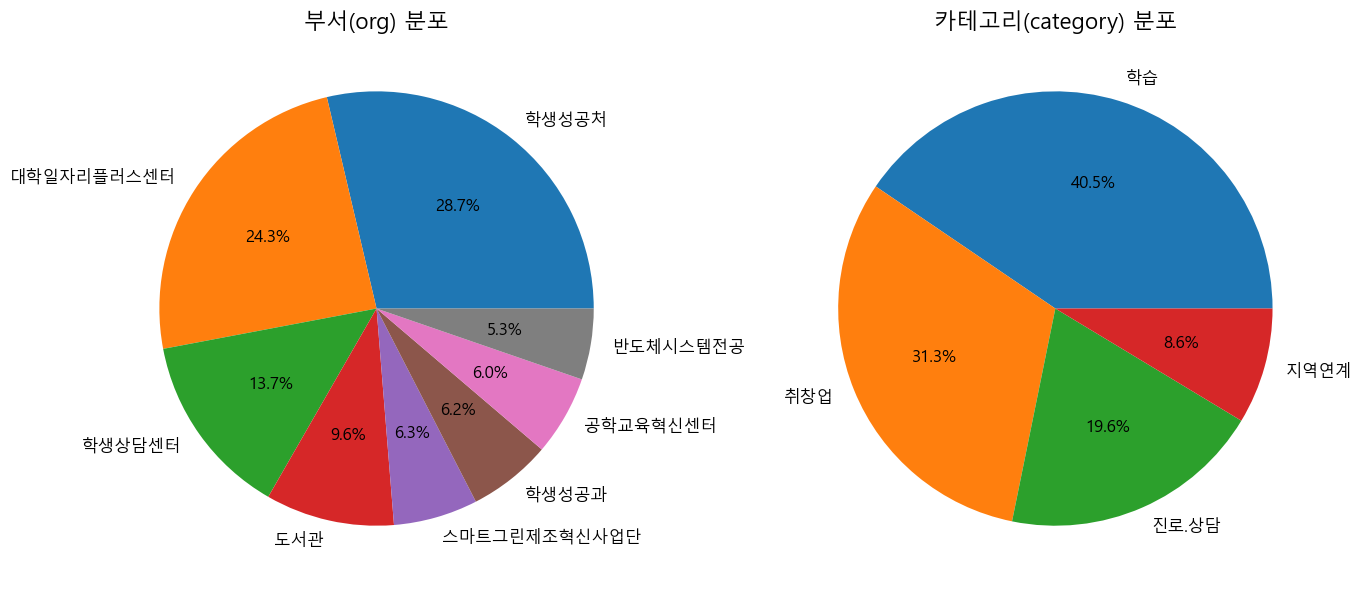

C:\Users\leejuhyung\AppData\Local\Temp\ipykernel_11944\3695471800.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=org_mileage.index,


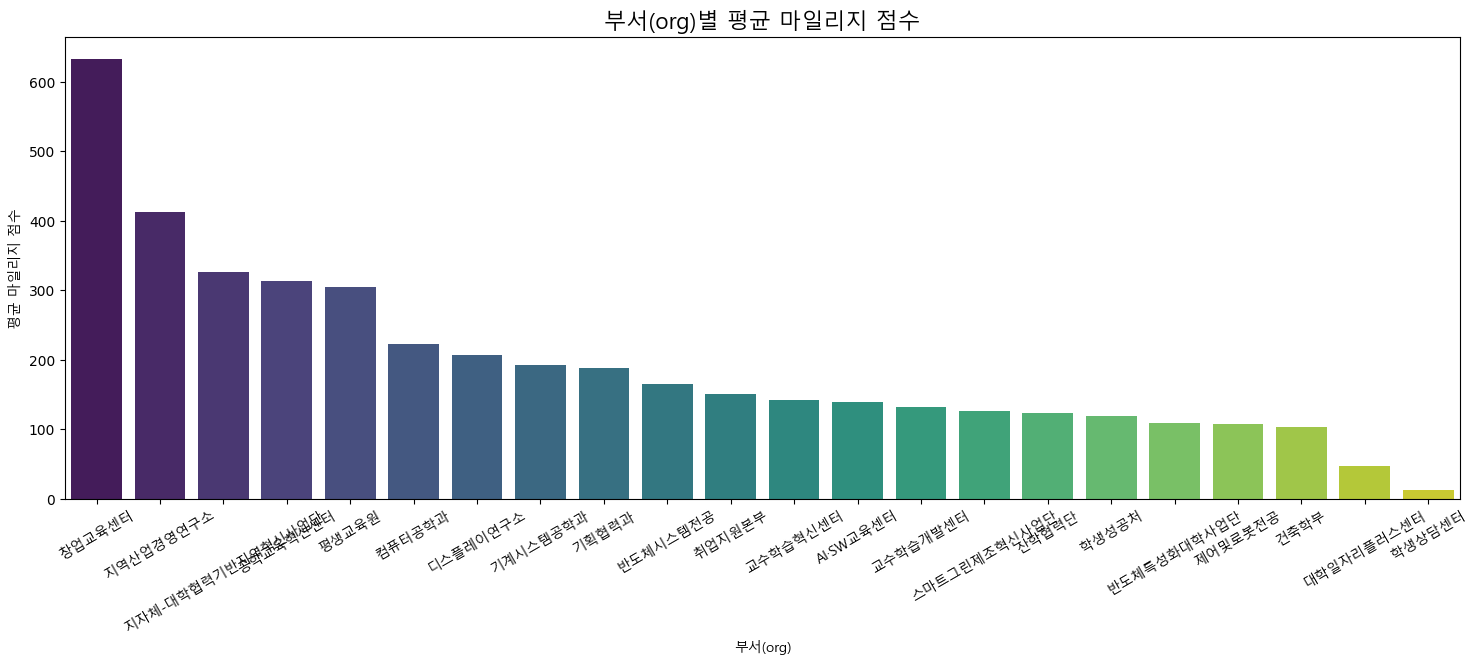

In [50]:
def exploratory_data_analysis(df):
    plt.figure(figsize=(14, 6))

    # 1. 부서(org) 분포 Pie Chart
    plt.subplot(1, 2, 1)
    org_counts = df['org'].value_counts(normalize=True) * 100
    org_counts = org_counts[org_counts >= 3] 

    plt.pie(org_counts.values,
            labels=org_counts.index,
            autopct='%1.1f%%',
            textprops={'fontproperties': fontprop, 'fontsize': 12})
    plt.title("부서(org) 분포", fontproperties=fontprop, fontsize=16, fontweight='bold')

    # 2. 카테고리(category) 분포 Pie Chart
    plt.subplot(1, 2, 2)
    category_counts = df['category'].value_counts()
    plt.pie(category_counts.values,
            labels=category_counts.index,
            autopct='%1.1f%%',
            textprops={'fontproperties': fontprop, 'fontsize': 12})
    plt.title("카테고리(category) 분포", fontproperties=fontprop, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 3. 부서(org)별 평균 마일리지 Bar Chart
    plt.figure(figsize=(18, 6))
    org_counts = df['org'].value_counts()
    org_counts = org_counts[org_counts >= 10]
    df = df[df['org'].isin(org_counts.index)]
    org_mileage = df.groupby('org')['mileage'].mean()
    org_mileage = org_mileage[org_mileage >= 100].sort_values(ascending=False)
    org_mileage['대학일자리플러스센터'] = df[df['org'] == '대학일자리플러스센터']['mileage'].mean()
    org_mileage['학생상담센터'] = df[df['org'] == '학생상담센터']['mileage'].mean()
    org_mileage = org_mileage.sort_values(ascending=False)

    sns.barplot(x=org_mileage.index,
                y=org_mileage.values,
                palette="viridis")

    plt.title("부서(org)별 평균 마일리지 점수", fontproperties=fontprop, fontsize=16, fontweight='bold')
    plt.xticks(rotation=30, fontproperties=fontprop)
    plt.ylabel("평균 마일리지 점수", fontproperties=fontprop)
    plt.xlabel("부서(org)", fontproperties=fontprop)

    plt.show()

# 분석 실행
exploratory_data_analysis(clean_df)

상위 키워드:
• 대학일자리센터: 246회
• 특강: 184회
• 교육: 174회
• 프로그램: 153회
• 온라인: 101회
• 전문가: 100회
• 릴레이: 98회
• 초청: 94회
• 집단: 84회
• 심리검사: 80회


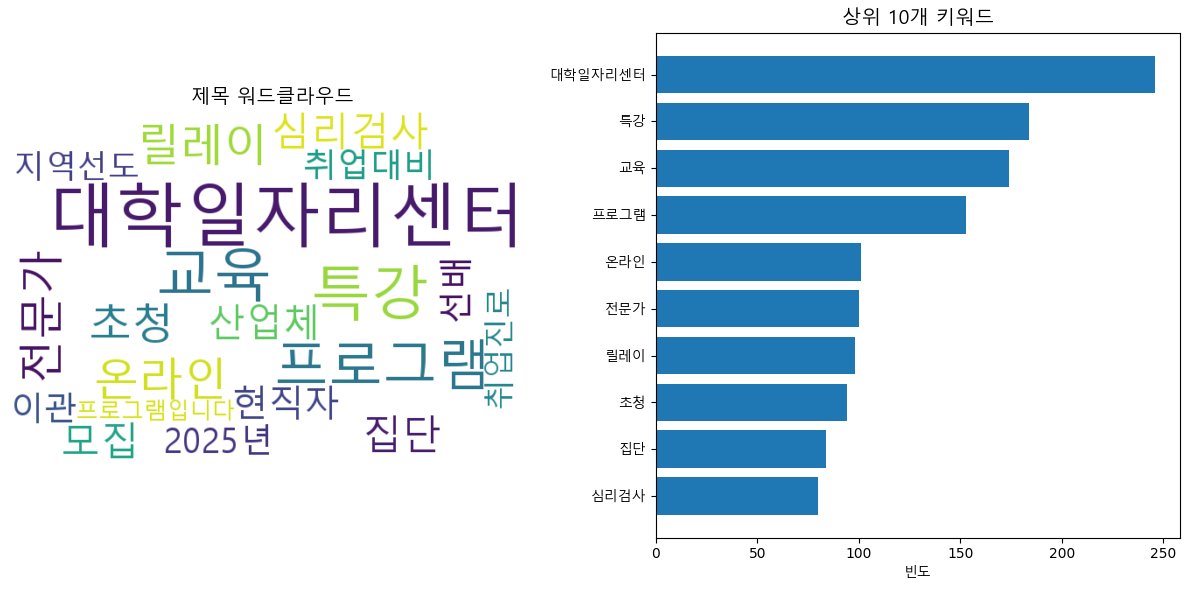

C:\Users\leejuhyung\AppData\Local\Temp\ipykernel_11944\4251813727.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=km_df, x='mean_mileage', y='keyword', palette='viridis')


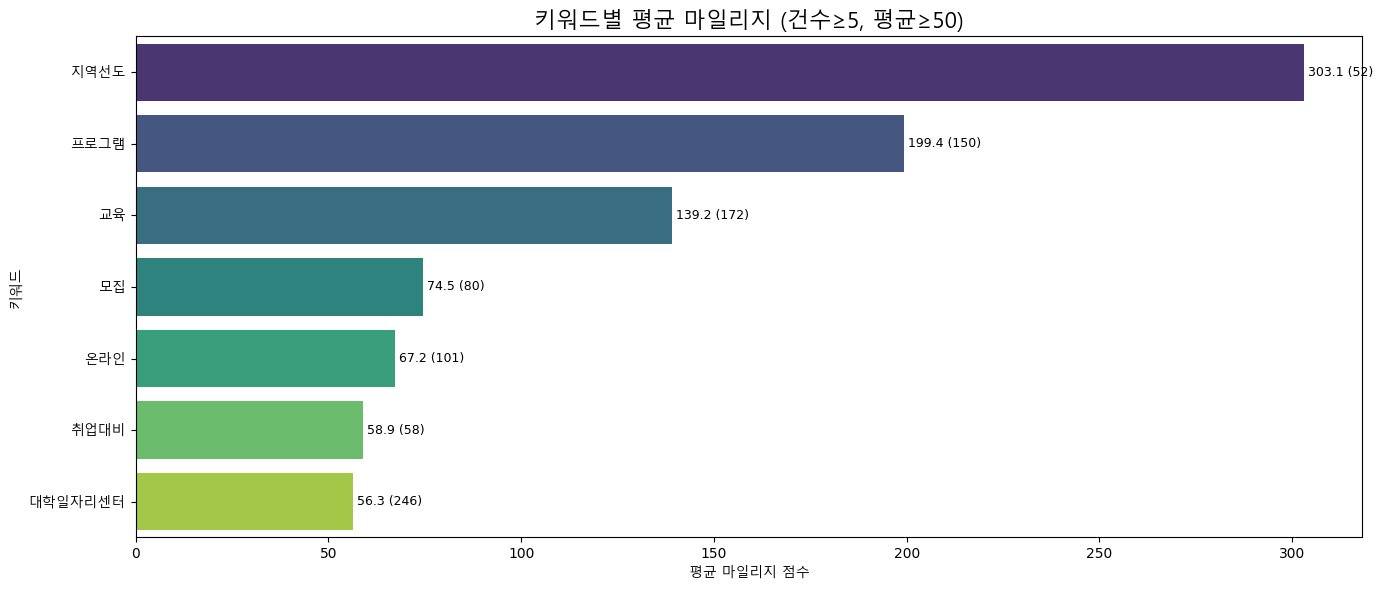

상위 키워드:
• 프로그램: 1365회
• 신청: 717회
• 취소: 426회
• 해석특강: 398회
• 대학일자리플러스센터: 377회
• 교육: 367회
• 시작: 352회
• 참여: 344회
• 취업지원팀: 335회
• 문의: 267회


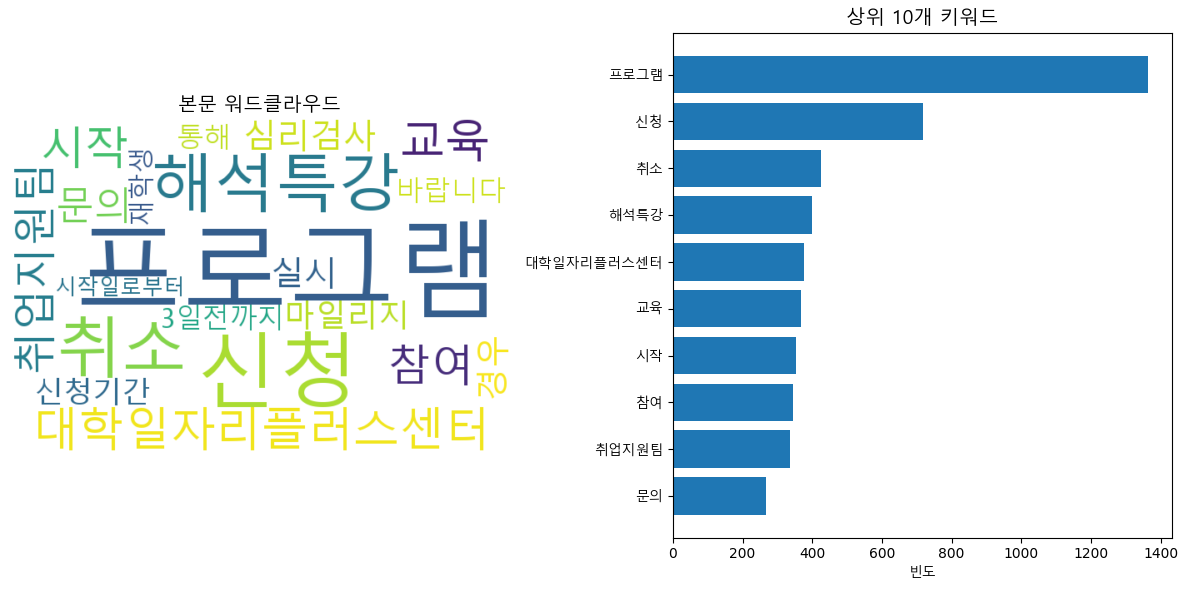

C:\Users\leejuhyung\AppData\Local\Temp\ipykernel_11944\4251813727.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=km_df, x='mean_mileage', y='keyword', palette='viridis')


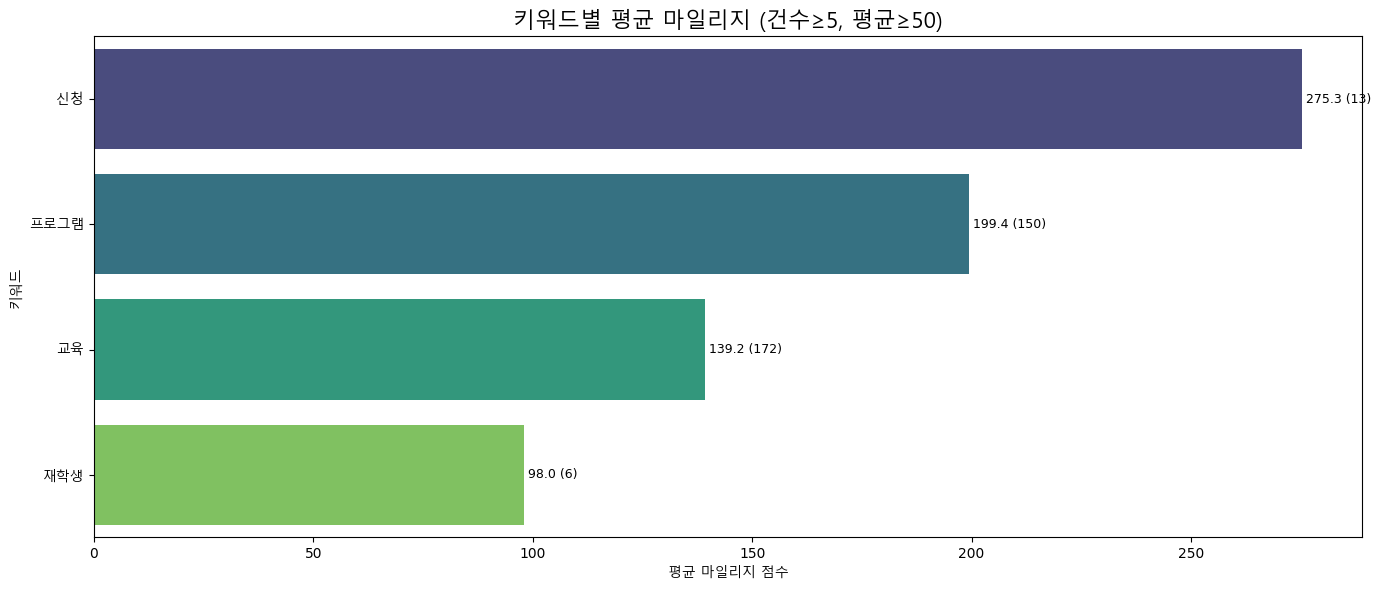

In [51]:
def draw_keyword_analysis(df, keywords):
    MIN_COUNT = 5    # 최소 출현 문서 수(원하면 낮춰도 됨)
    MIN_MEAN  = 50  # 평균 마일리지 하한

    candidate_words = [w for w, _ in keywords]
    title_series = df['title_clean'].fillna('')

    rows = []
    for w in candidate_words:
        mask = title_series.str.contains(rf'(?<!\w){re.escape(w)}(?!\w)', case=False)
        cnt = int(mask.sum())
        if cnt == 0:
            continue
        mean_m = float(df.loc[mask, 'mileage'].mean())
        rows.append((w, mean_m, cnt))

    if rows:
        km_df = pd.DataFrame(rows, columns=['keyword', 'mean_mileage', 'count'])
        km_df = km_df[(km_df['count'] >= MIN_COUNT) & (km_df['mean_mileage'] >= MIN_MEAN)] \
                    .sort_values('mean_mileage', ascending=False)

        if not km_df.empty:
            plt.figure(figsize=(14, max(6, 0.5 * len(km_df))))
            sns.barplot(data=km_df, x='mean_mileage', y='keyword', palette='viridis')
            plt.xlabel("평균 마일리지 점수", fontproperties=fontprop)
            plt.ylabel("키워드", fontproperties=fontprop)
            plt.title(f"키워드별 평균 마일리지 (건수≥{MIN_COUNT}, 평균≥{MIN_MEAN})",
                      fontproperties=fontprop, fontsize=16, fontweight='bold')
            plt.yticks(fontproperties=fontprop)

            for i, (val, cnt) in enumerate(zip(km_df['mean_mileage'], km_df['count'])):
                plt.text(val, i, f" {val:.1f} ({cnt})", va='center', ha='left', fontsize=9)

            plt.tight_layout()
            plt.show()
        else:
            print("조건(건수/평균) 충족 키워드가 없습니다.")
    else:
        print("키워드별 평균 마일리지 계산 대상이 없습니다.")

def advanced_visualization(df):
    if 'title_clean' not in df.columns:
        return
    
    keywords = extract_keywords(df['title_clean'])
    if not keywords:
        print("추출된 키워드가 없습니다.")
        return
    
    print("상위 키워드:")
    for word, freq in keywords[:10]:
        print(f"• {word}: {freq}회")
    
    font_path = r"C:\Windows\Fonts\malgun.ttf"

    keyword_dict = {w: f for w, f in keywords}

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    wc = WordCloud(
        width=600, height=400,
        background_color='white',
        max_words=100,
        font_path=font_path
    ).generate_from_frequencies(keyword_dict)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('제목 워드클라우드', fontproperties=fontprop, fontsize=14, fontweight='bold')
    
    plt.subplot(1, 2, 2)
    top10 = keywords[:10]
    words, freqs = zip(*top10)
    
    plt.barh(range(len(words)), freqs)
    plt.yticks(range(len(words)), words, fontproperties=fontprop)
    plt.xlabel('빈도', fontproperties=fontprop)
    plt.title('상위 10개 키워드', fontproperties=fontprop, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    draw_keyword_analysis(df, keywords)


def advanced_visualization_text(df):
    if 'text_clean' not in df.columns:
        return

    keywords = extract_keywords(df['text_clean'])
    if not keywords:
        print("추출된 키워드가 없습니다.")
        return
    
    print("상위 키워드:")
    for word, freq in keywords[:10]:
        print(f"• {word}: {freq}회")
    
    font_path = r"C:\Windows\Fonts\malgun.ttf"

    keyword_dict = {w: f for w, f in keywords}

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    wc = WordCloud(
        width=600, height=400,
        background_color='white',
        max_words=100,
        font_path=font_path
    ).generate_from_frequencies(keyword_dict)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('본문 워드클라우드', fontproperties=fontprop, fontsize=14, fontweight='bold')
    
    plt.subplot(1, 2, 2)
    top10 = keywords[:10]
    words, freqs = zip(*top10)
    plt.barh(range(len(words)), freqs)
    plt.yticks(range(len(words)), words, fontproperties=fontprop)
    plt.xlabel('빈도', fontproperties=fontprop)
    plt.title('상위 10개 키워드', fontproperties=fontprop, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    draw_keyword_analysis(df, keywords)

# 실행
advanced_visualization(clean_df)
advanced_visualization_text(clean_df)
